In [79]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [82]:
!rm -rf gromacs_and_plumed_pytorch
!unzip /content/drive/MyDrive/gromacs_and_plumed_pytorch-20240530T140144Z-001.zip -d .

Streaming output truncated to the last 5000 lines.
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_64.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t3fv_20.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t2fv_32.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_15.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t1fv_12.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwBuild-prefix/src/fftwBuild/dft/simd/avx/t2fv_4.c  
  inflating: ./gromacs_and_plumed_pytorch/gromacs-2022.3/build/src/external/build-fftw/fftwB

In [84]:
!rm -rf plumed_pytorch_tutorial
!git clone https://github.com/dhimanray/plumed_pytorch_tutorial.git

Cloning into 'plumed_pytorch_tutorial'...
remote: Enumerating objects: 12, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 12 (delta 0), reused 9 (delta 0), pack-reused 0
Receiving objects: 100% (12/12), 102.07 KiB | 829.00 KiB/s, done.


## **Simulation of Toy Model: Mueller Brown Potential**

In [94]:

#Create the folder with the necessary input files
import os
path = '/content/plumed_pytorch_tutorial/mueller/'
#os.system('rm -r %s'%path)
#os.system('mkdir %s'%path)
os.system('cd %s'%path)

#Copy the MD potential file
#os.system('ln -s /content/drive/MyDrive/input_md-potential.dat %s/'%path)

#Copy the pytorch file
#os.system('ln -s /content/drive/MyDrive/mueller_2state_model.pt %s/'%path)

## PLUMED INPUT FILE FOR ENHANCED SAMPLING (MODIFY AS NEEDED) ##
plumed_input = """
UNITS NATURAL

p: POSITION ATOM=1
mueller: CUSTOM ARG=p.x,p.y PERIODIC=NO ...
  FUNC=0.15*(-200*exp(-(x-1)^2-10*y^2)-100*exp(-x^2-10*(y-0.5)^2)-170*exp(-6.5*(0.5+x)^2+11*(x+0.5)*(y-1.5)-6.5*(y-1.5)^2)+15*exp(0.7*(1+x)^2+0.6*(x+1)*(y-1)+0.7*(y-1)^2)+146.7)
...
potential: BIASVALUE ARG=mueller
lwall: LOWER_WALLS ARG=p.x KAPPA=1000 AT=-1.3
uwall: UPPER_WALLS ARG=p.x KAPPA=1000 AT=+1.0

deepTDA_2D: PYTORCH_MODEL FILE=mueller_2state_model.pt ARG=p.x,p.y

opes: OPES_METAD ...
  ARG=p.y
  PACE=500
  BARRIER=30
...


PRINT FMT=%g STRIDE=50 FILE=COLVAR ARG=p.x,p.y,deepTDA_2D.node-0,mueller,opes.bias


ENDPLUMED"""

with open('%s/plumed.dat'%path, 'w') as file:
  file.write(plumed_input)

##Simulation Input file
input_md = """
nstep             2000000
tstep             0.005
temperature       1.0
friction          10.0
random_seed       567
plumed_input      plumed.dat
dimension         2
replicas          1
basis_functions_1 BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
basis_functions_2 BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
input_coeffs       input_md-potential.dat
initial_position   -0.693111,1.40842
output_coeffs           /dev/null
output_potential        /dev/null
output_potential_grid   10
output_histogram        /dev/null
"""
with open('%s/input_md.dat'%path, 'w') as file:
  file.write(input_md)



In [95]:
%%bash
##------- source plumed pytorch interface -----------------------
rm -r plumed2-master
ln -s gromacs_and_plumed_pytorch/plumed2-master .
chmod +x plumed2-master/*
chmod +x plumed2-master/*/*
chmod +x plumed2-master/src/lib/plumed
source plumed2-master/libtorch/sourceme.sh
source plumed2-master/sourceme.sh
##---------------------------------------------------------------

##copy toy model files
cd /content/plumed_pytorch_tutorial/mueller/

cat input_md-potential.dat

plumed ves_md_linearexpansion input_md.dat

#! FIELDS idx_dim1 idx_dim2 pot.coeffs index description
#! SET type LinearBasisSet
#! SET ndimensions  2
#! SET ncoeffs_total  3
#! SET shape_dim1  2
#! SET shape_dim2  2
       0       0         1.0000000000000000e+00       0  1*1
       1       0         0.0000000000000000e+00       1  s^1*1
       0       1         0.0000000000000000e+00       2  1*s^1
#!-------------------
Replicas                              1
Cores per replica                     1
Number of steps                       2000000
Timestep                              0.005000
Temperature                           1.000000
Friction                              10.000000
Random seed                           -567
Dimensions                            2
Basis Function 1                      BF_POWERS ORDER=1 MINIMUM=-4.0 MAXIMUM=+3.0
Basis Function 2                      BF_POWERS ORDER=1 MINIMUM=-1.0 MAXIMUM=+2.5
PLUMED input                          plumed.dat
kBoltzmann taken as 1, use NATURAL_UNITS in the plumed 

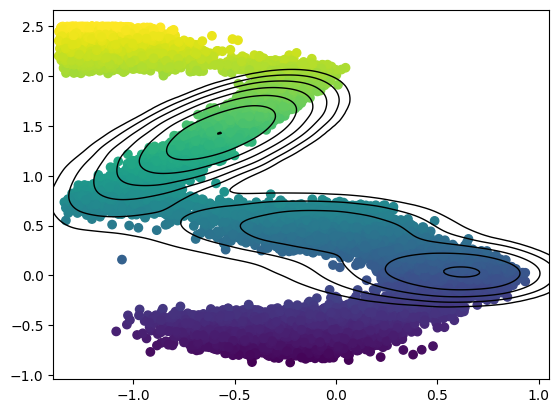

In [96]:
import numpy as np
import matplotlib.pyplot as plt
import scipy

N = 200 #number of points for plotting/interpolation

m = 40   #number of contours

x, y, z = np.genfromtxt(r'plumed_pytorch_tutorial/mueller/2d_fes', unpack=True)

for i in range(len(z)):
    if z[i] >= 20.0:
        z[i] = 20
xi = np.linspace(x.min(), x.max(), N)
yi = np.linspace(y.min(), y.max(), N)
zi = scipy.interpolate.griddata((x, y), z, (xi[None,:], yi[:,None]), method='cubic')

X, Y = np.meshgrid(xi, yi)
plt.contour(X,Y,zi,colors='black', linewidths=1)

l = np.loadtxt('plumed_pytorch_tutorial/mueller/COLVAR')

plt.scatter(l[:,1],l[:,2],c=l[:,2])

In [97]:
#Calculate 1D Free energy profile along x
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.x --kt 1.0 --sigma 0.05 -o fes_x_test


 using cv "p.x" found at column 2
 using bias "opes.bias" found at column 6
                              


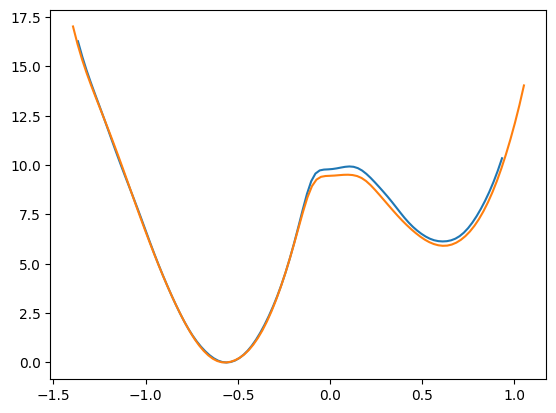

In [98]:
fes_x_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x_test')
fes_x_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_x')

plt.plot(fes_x_test[:,0],fes_x_test[:,1])
plt.plot(fes_x_ref[:,0],fes_x_ref[:,1])

In [99]:
#Calculate 1D Free energy profile along y axis
!cd plumed_pytorch_tutorial/mueller && python FES_from_Reweighting.py --colvar COLVAR --cv p.y --kt 1.0 --sigma 0.05 -o fes_y_test


 using cv "p.y" found at column 3
 using bias "opes.bias" found at column 6
                              


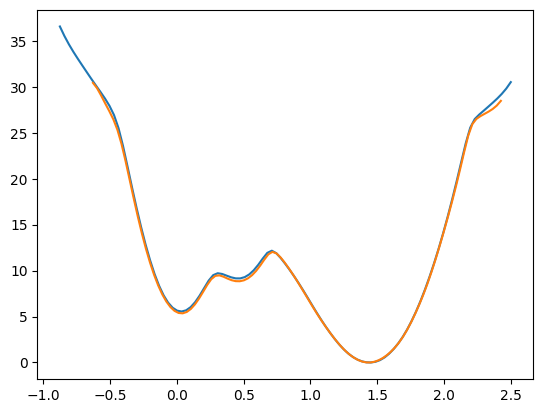

In [100]:
fes_y_test = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y_test')
fes_y_ref = np.loadtxt('plumed_pytorch_tutorial/mueller/fes_y')

plt.plot(fes_y_test[:,0],fes_y_test[:,1])
plt.plot(fes_y_ref[:,0],fes_y_ref[:,1])